In [1]:
import cv2
import mediapipe as mp
import os
import numpy as np
import math
import json


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from copy import deepcopy

# POINT EXTRACTION
I've used the mediapipe library to extract 3 coordinates (x,y,z) of 21 points of a single hand, from a series of hand pictures.
Resulting in 2386 samples * 21 points per hand * 3 coordinates per hand of 25 different characters.
Since I don't have enough computational power to process it all I have split the data in batches and stored the results in a txt file

In [ ]:
mp_hands = mp.solutions.hands

In [ ]:
#Resize the images
def resize_image(img,DESIRED_HEIGHT = 480, DESIRED_WIDTH = 480):
    h, w = img.shape[:2]
    if h < w:
        img = cv2.resize(img, (DESIRED_WIDTH, math.floor(h/(w/DESIRED_WIDTH))))
    else:
        img = cv2.resize(img, (math.floor(w/(h/DESIRED_HEIGHT)), DESIRED_HEIGHT))
    return img

In [ ]:
#Mediapipe does not work well if the image is near the image limits so we add a border if needed
def add_border(img, border_size=150):
    img = cv2.copyMakeBorder(img, top=border_size, bottom=border_size, left=border_size, right=border_size, borderType=cv2.BORDER_CONSTANT, 
                               value=[0, 0, 0] )
    return img

In [ ]:
# We call mediapipe to extract the points. If mediapipe is unable to do so we add a border and try again.
def get_points(img):
    hands = mp_hands.Hands(min_detection_confidence=0.5, min_tracking_confidence=0.5)
    results = hands.process(cv2.flip(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), 1))
    points = []
        
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            for i in range(21):
                x = hand_landmarks.landmark[i].x
                y = hand_landmarks.landmark[i].y
                z = hand_landmarks.landmark[i].z
                points.append([x, y, z])  
    else:
        img = add_border(img)
        results = hands.process(cv2.flip(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), 1))
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                for i in range(21):
                    x = hand_landmarks.landmark[i].x
                    y = hand_landmarks.landmark[i].y
                    z = hand_landmarks.landmark[i].z
                    points.append([x, y, z]) 
        else:
            points = None
        
    return points

In [ ]:
#We scale all points.
def scale_points(p):
    if p is not None:
        p = np.array(p)
        min_x = np.min(p[:, 0])
        max_x = np.max(p[:, 0])
        min_y = np.min(p[:, 1])
        max_y = np.max(p[:, 1])
        min_z = np.min(p[:, 2])
        max_z = np.max(p[:, 2])
        for pp in p:
            pp[0] = (pp[0] - min_x) / (max_x - min_x)
            pp[1] = (pp[1] - min_y) / (max_y - min_y)
            pp[2] = (pp[2] - min_z) / (max_z - min_z)
    return p

In [ ]:
#Import train set
test_set=[]
character_len_dic ={}

path= 'working/train'
character_types = ['d']


for character in character_types:
    dir_path = f'{path}/{character}'
    character_len_dic[character] = len(os.listdir(dir_path))
    for img in os.listdir(dir_path):
        print(character,img)
        im_path = f'{dir_path}/{img}'
        image = cv2.imread(im_path,cv2.IMREAD_COLOR)
        image = resize_image(image)
        image_points = get_points(image)
        hand_points = scale_points(image_points)
        image_label = character
        if hand_points is not None: 
            test_set.append((hand_points, image_label))

with open(r'image_tensor.txt', 'a') as fp:
    fp.write("\n".join(str(item) for item in test_set))

In [ ]:
#Import test set
test_set=[]
character_len_dic ={}

path= 'working/test'
character_types = ['u','v','w','x','y','z']


for character in character_types:
    dir_path = f'{path}/{character}'
    character_len_dic[character] = len(os.listdir(dir_path))
    for img in os.listdir(dir_path):
        print(character,img)
        im_path = f'{dir_path}/{img}'
        image = cv2.imread(im_path,cv2.IMREAD_COLOR)
        image = resize_image(image)
        image_points = get_points(image)
        hand_points = scale_points(image_points)
        image_label = character
        if hand_points is not None: 
            test_set.append((hand_points, image_label))

with open(r'image_tensor_test.txt', 'a') as fp:
    fp.write("\n".join(str(item) for item in test_set))

In [ ]:
#Import val set
val_set=[]
character_len_dic ={}

path= 'working/val'
character_types = ['y','z']


for character in character_types:
    dir_path = f'{path}/{character}'
    character_len_dic[character] = len(os.listdir(dir_path))
    for img in os.listdir(dir_path):
        print(character,img)
        im_path = f'{dir_path}/{img}'
        image = cv2.imread(im_path,cv2.IMREAD_COLOR)
        image = resize_image(image)
        image_points = get_points(image)
        hand_points = scale_points(image_points)
        image_label = character
        if hand_points is not None: 
            val_set.append((hand_points, image_label))

with open(r'image_tensor_val.txt', 'a') as fp:
    fp.write("\n".join(str(item) for item in val_set))

# .txt load and preprocess
Since we have stored our data in a txt file we need to extract it to be able to process it

In [37]:
#Load training set
image_set=[]

with open(r'image_tensor.txt', 'r') as fp:
    data = fp.read()
    image_set = data.split("\n") 


In [38]:
new_set=[]
element=''
for i in image_set:
    if i !='':
        if i[-1] == ')':
            element = element + i
            new_set.append(element)
            element = ''
        else:
            element = element + i


In [39]:
test1=[]
for element in new_set:
     b=element[-3]
     a=element[:-7]
     a=a[7:]
     test1.append((a,b))

In [40]:
ones=np.identity(26)

In [52]:
my_library={}
for item in test1:
    if item[1] in my_library.keys():
        my_library[item[1]] +=1
    else:
        my_library[item[1]] =1

In [76]:
import matplotlib.pyplot as plt

names = list(my_library.keys())
values = list(my_library.values())


In [43]:
labels_dict={}
for i in range(len(names)):
    labels_dict[names[i]] =ones[i]

In [44]:
torch_set=[]
for i in range(len(test1)):
    a = eval(test1[i][0])
    c = torch.tensor(np.transpose(np.asarray(a)),dtype=torch.float32)
    b = test1[i][1]
    d = torch.tensor(labels_dict[b],dtype=torch.float32)
    torch_set.append((c,d))


In [45]:
#Load test data
test_image_set=[]
i=0
with open(r'image_tensor_test.txt', 'r') as ft:
    datatest = ft.read()
    element=''
    for letter in datatest:
        element = element + letter
        i+=1
        if element[-1:] =='\n':
            element.replace(" ", "")
            test_image_set.append(element[:-1])
            element=''


In [46]:
test_new_set=[]
element=''
for i in test_image_set:
    if i !='':
        if i[-1] == ')':
            element = element + i
            test_new_set.append(element)
            element = ''
        else:
            element = element + i

In [47]:
test2=[]
for element in test_new_set:
    x=element[-3]
    y=element[:-7]
    y=y[7:]
    test2.append((y,x))

In [48]:
test_set=[]
for i in range(len(test2)):
    e = eval(test2[i][0])
    f = torch.tensor(np.transpose(np.asarray(e)),dtype=torch.float32)
    g = test2[i][1]
    h = torch.tensor(labels_dict[g],dtype=torch.float32)
    test_set.append((f,h))

In [49]:
#Load val data
val_image_set=[]
i=0
with open(r'image_tensor_val.txt', 'r') as ft:
    datatest = ft.read()
    element=''
    for letter in datatest:
        element = element + letter
        i+=1
        if element[-1:] =='\n':
            element.replace(" ", "")
            val_image_set.append(element[:-1])
            element=''

val_new_set=[]
element=''
for i in val_image_set:
    if i !='':
        if i[-1] == ')':
            element = element + i
            val_new_set.append(element)
            element = ''
        else:
            element = element + i
            
test3=[]
for element in val_new_set:
    x=element[-3]
    y=element[:-7]
    y=y[7:]
    test3.append((y,x))

val_set=[]
for i in range(len(test3)):
    e = eval(test2[i][0])
    f = torch.tensor(np.transpose(np.asarray(e)),dtype=torch.float32)
    g = test2[i][1]
    h = torch.tensor(labels_dict[g],dtype=torch.float32)
    val_set.append((f,h))

In [50]:
n_images_train = len(torch_set)
n_images_test = len(test_set)
n_images_val = len(val_set)

In [54]:
for item in test2:
    if item[1] in my_library.keys():
        my_library[item[1]] +=1
    else:
        my_library[item[1]] =1
        
for item in test3:
    if item[1] in my_library.keys():
        my_library[item[1]] +=1
    else:
        my_library[item[1]] =1

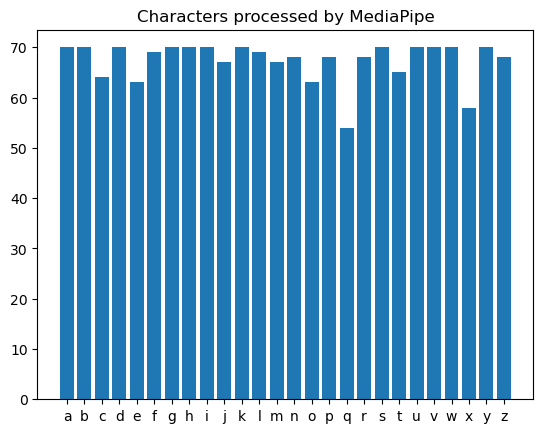

In [77]:
import matplotlib.pyplot as plt

names = list(my_library.keys())
values = list(my_library.values())

plt.bar(range(len(my_library)), values, tick_label=names)
plt.title("Characters processed by MediaPipe")
plt.show()

Here we can see that MediaPipe has issues extracting points from the character q and x

# MODEL
We will train the model with a modification of the PointNet Architecture, which is good interpretating clouds of points. The benefits of this aplication is that it is able to interpretate the coordenates regardless of its orientation in the 3D space (invariant to all rotations).
https://datascienceub.medium.com/pointnet-implementation-explained-visually-c7e300139698

In [56]:
class PointNet(nn.Module):
    def __init__(self):
        super(PointNet, self).__init__()

        self.box1 = nn.Sequential(nn.Conv1d(3, 64, kernel_size=1, stride=1), nn.BatchNorm1d(64), nn.ReLU())

        self.box2 = nn.Sequential(nn.Conv1d(64, 64, kernel_size=1, stride=1), nn.BatchNorm1d(64), nn.ReLU())

        self.box3 = nn.Sequential(nn.Conv1d(64, 64, kernel_size=1, stride=1), nn.BatchNorm1d(64), nn.ReLU())

        self.box4 = nn.Sequential(nn.Conv1d(64, 128, kernel_size=1, stride=1), nn.BatchNorm1d(128), nn.ReLU())

        self.box5 = nn.Sequential(nn.Conv1d(128, 1024, kernel_size=1, stride=1), nn.BatchNorm1d(1024), nn.ReLU())

        self.mp = nn.MaxPool1d(21)

        #self.box6 = nn.Sequential(nn.Linear(1024, 512), nn.BatchNorm1d(512), nn.ReLU())
        self.box6 = nn.Sequential(nn.Linear(1024, 512), nn.ReLU())

        #self.box7 = nn.Sequential(nn.Linear(512, 256), nn.BatchNorm1d(256), nn.ReLU())
        self.box7 = nn.Sequential(nn.Linear(512, 256),  nn.ReLU())

        self.box8 = nn.Linear(256, 26) #26 characters

    def forward(self, x):
        
        x = self.box1(x)
        #print('box1: ',x.shape)
        x = self.box2(x)
        #print('box2: ',x.shape)
        x = self.box3(x)
        #print('box3: ',x.shape)
        x = self.box4(x)
        #print('box4: ',x.shape)
        x = self.box5(x)
        #print('box5: ',x.shape)

        x = self.mp(x)
        #print('mp: ',x.shape)
        #x = torch.flatten(x,1) #flatten
        x = x.reshape(-1,1024)
        #print('flatten: ',x.shape)

        x = self.box6(x)
        #print('box6: ',x.shape)
        x = self.box7(x)
        #print('box7: ',x.shape)
        x = F.softmax(self.box8(x),dim=1)
        #print('box8: ',x.shape)

        return x

    def get_number_of_parameters(self):
        return sum(p.numel() for p in self.parameters())

# Training 
To train the model we will use the Adam optimizer and Cross Entropy loss function

In [57]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = PointNet().to(device)

print('model number of parameters:', model.get_number_of_parameters())

model number of parameters: 814490


In [58]:
train_loader = DataLoader(torch_set, batch_size=7, shuffle=True, drop_last=True)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)
val_loader = DataLoader(val_set, batch_size=4, shuffle=False)

loss_function = CrossEntropyLoss()

optimizer = Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)

In [59]:
epochs = 60

train_loss, train_accuracy = [], []
val_loss, val_accuracy = [], []
test_loss, test_accuracy = [], []
best_model = deepcopy(model)
best_val_loss = torch.inf

for epoch in range(epochs):
    model.train()
    train_loss_epoch, train_accuracy_epoch = 0,0
    for img, labels in train_loader:
        input_data = img.to(device)
        labels = labels.to(device)
        outputs = model(input_data)
        loss = loss_function(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss_epoch += loss.item() * len(labels)
        correct = torch.argmax(outputs, dim=1) == torch.argmax(labels, dim=1)
        train_accuracy_epoch += correct.sum().item()


    train_loss_epoch /= n_images_train
    train_accuracy_epoch /= (n_images_train / 100)
    train_loss.append(train_loss_epoch)
    train_accuracy.append(train_accuracy_epoch)

    model.eval()
    test_loss_epoch, test_accuracy_epoch = 0, 0
    for img, labels in test_loader:
        input_data = img.to(device)
        labels = labels.to(device)
        outputs = model(input_data)
        loss = loss_function(outputs, labels)
        test_loss_epoch += loss.item() * len(labels)
        correct = torch.argmax(outputs, dim=1) == torch.argmax(labels, dim=1)
        test_accuracy_epoch += correct.sum().item()

    test_loss_epoch /= n_images_val
    test_accuracy_epoch /= (n_images_test / 100)
    test_loss.append(test_loss_epoch)
    test_accuracy.append(test_accuracy_epoch)
    
    val_loss_epoch, val_accuracy_epoch = 0, 0
    for img, labels in val_loader:
        input_data = img.to(device)
        labels = labels.to(device)
        outputs = model(input_data)
        loss = loss_function(outputs, labels)
        val_loss_epoch += loss.item() * len(labels)
        correct = torch.argmax(outputs, dim=1) == torch.argmax(labels, dim=1)
        val_accuracy_epoch += correct.sum().item()
        
    val_loss_epoch /= n_images_val
    val_accuracy_epoch /= (n_images_val / 100)
    val_loss.append(val_loss_epoch)
    val_accuracy.append(val_accuracy_epoch)

    if val_loss_epoch < best_val_loss:
        best_val_loss = val_loss_epoch
        best_model = deepcopy(model)

    print('epoch: {}, training loss: {:.3f}, test loss: {:.3f}, val loss: {:.3f}'.format(epoch+1, train_loss_epoch, test_loss_epoch, val_loss_epoch))
    print('epoch: {}, training accuracy: {:.2f}%, test accuracy: {:.2f}%, val accuracy: {:.2f}% \n'.format(epoch+1, train_accuracy_epoch, test_accuracy_epoch, val_accuracy_epoch))

epoch: 1, training loss: 3.243, test loss: 3.229, val loss: 3.192
epoch: 1, training accuracy: 5.71%, test accuracy: 11.36%, val accuracy: 11.49% 

epoch: 2, training loss: 3.134, test loss: 3.127, val loss: 3.089
epoch: 2, training accuracy: 18.27%, test accuracy: 21.59%, val accuracy: 21.84% 

epoch: 3, training loss: 3.045, test loss: 3.053, val loss: 3.020
epoch: 3, training accuracy: 27.34%, test accuracy: 31.25%, val accuracy: 31.03% 

epoch: 4, training loss: 2.986, test loss: 2.964, val loss: 2.931
epoch: 4, training accuracy: 33.69%, test accuracy: 39.20%, val accuracy: 39.08% 

epoch: 5, training loss: 2.957, test loss: 2.960, val loss: 2.927
epoch: 5, training accuracy: 36.05%, test accuracy: 39.77%, val accuracy: 39.66% 

epoch: 6, training loss: 2.926, test loss: 2.969, val loss: 2.937
epoch: 6, training accuracy: 39.47%, test accuracy: 38.64%, val accuracy: 38.51% 

epoch: 7, training loss: 2.926, test loss: 2.911, val loss: 2.879
epoch: 7, training accuracy: 39.54%, test

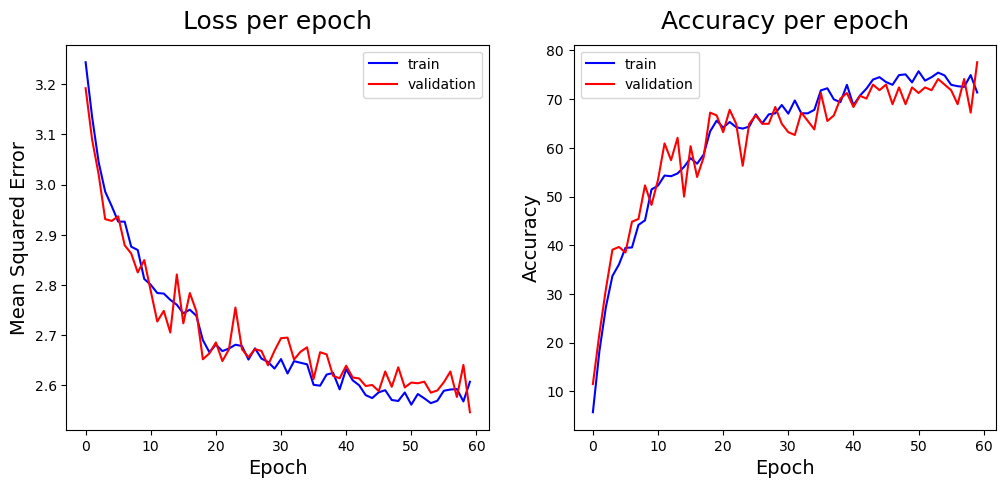

In [60]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].plot(train_loss, c='b', label='train')
ax[0].plot(val_loss, c='r', label='validation')
ax[0].set_xlabel('Epoch', fontsize=14)
ax[0].set_ylabel('Mean Squared Error', fontsize=14)
ax[0].set_title('Loss per epoch', fontsize=18, y=1.02)
ax[0].legend()
ax[1].plot(train_accuracy, c='b', label='train')
ax[1].plot(val_accuracy, c='r', label='validation')
ax[1].set_xlabel('Epoch', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)
ax[1].set_title('Accuracy per epoch', fontsize=18, y=1.02)
ax[1].legend()

Here we can see a visualization of the training process. We can see how the loss decreases and the accuracy increases

# Model Evaluation

In [61]:
decript_dict={}
for i in range(len(list(my_library.keys()))):
    decript_dict[i]=list(my_library.keys())[i]

In [63]:
best_model.eval()
forecasts=[]
test_accuracy = 0
for img, labels in test_loader:
    input_data = img.to(device)
    labels = labels.to(device)
    outputs = best_model(input_data)
    correct = torch.argmax(outputs, dim=1) == torch.argmax(labels, dim=1)
    test_accuracy += correct.sum().item()
    forecasts.append((decript_dict[torch.argmax(labels, dim=1).item()],decript_dict[torch.argmax(outputs, dim=1).item()]))
test_accuracy /= n_images_test

print('The accuracy on the test set of the best model is {:.2f}%'.format(100 * test_accuracy))

The accuracy on the test set of the best model is 77.27%


In [65]:
import pandas as pd

df=pd.DataFrame(forecasts, columns=['label','prediction'])

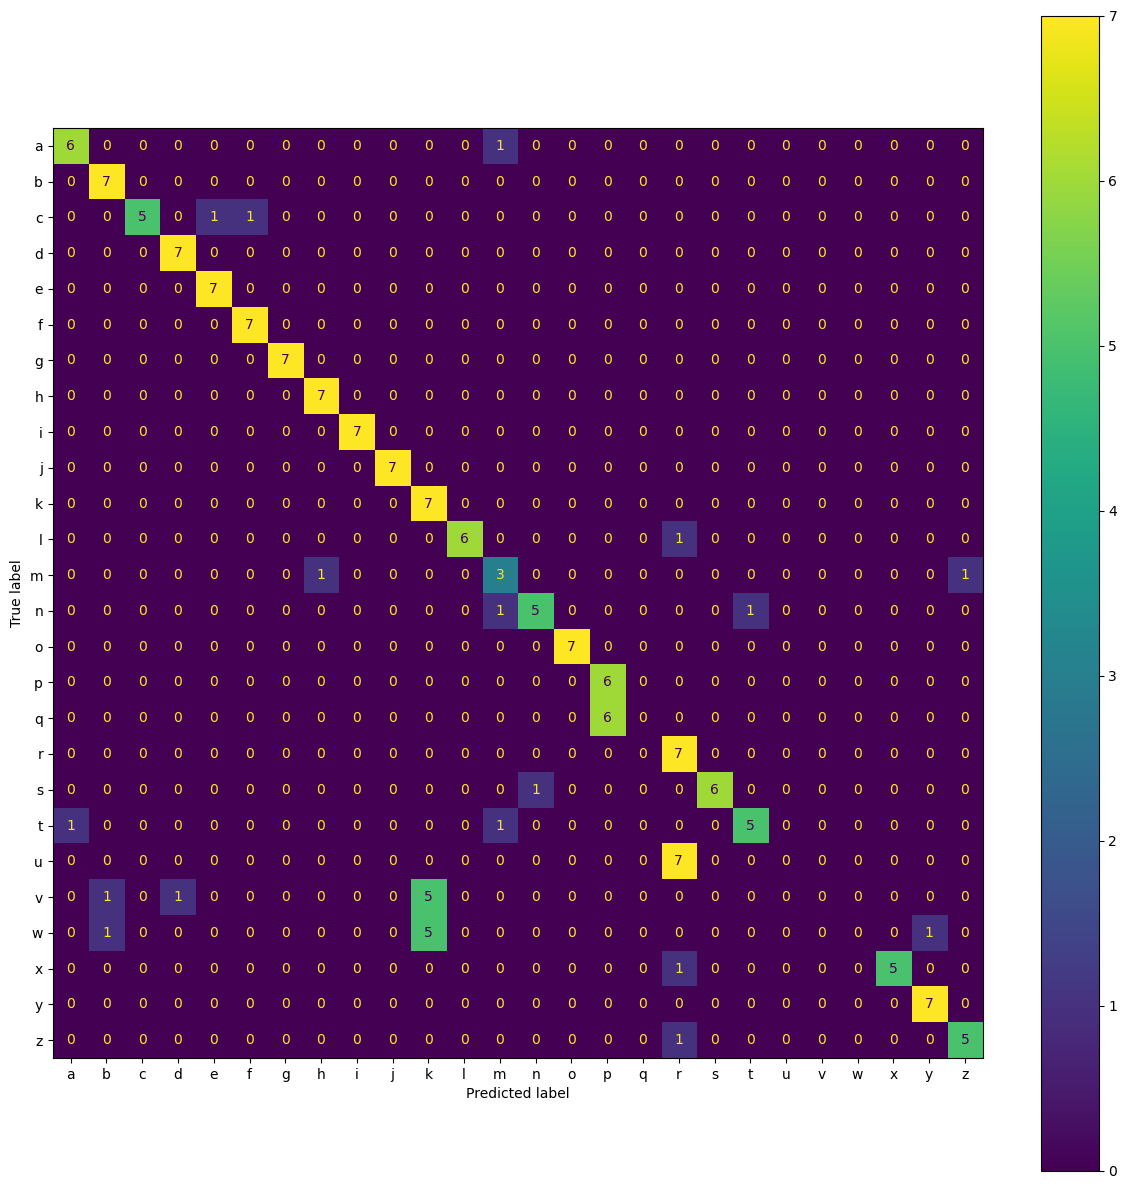

In [66]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

actual = df['label']
predicted = df['prediction']

confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = list(decript_dict.values()))

fig, ax = plt.subplots(figsize=(15,15))
cm_display.plot(ax=ax)

In [67]:
fig.savefig("confusion_PointNet.png")

In [69]:
df['correct']=df['label']==df['prediction']

In [70]:
import seaborn as sns

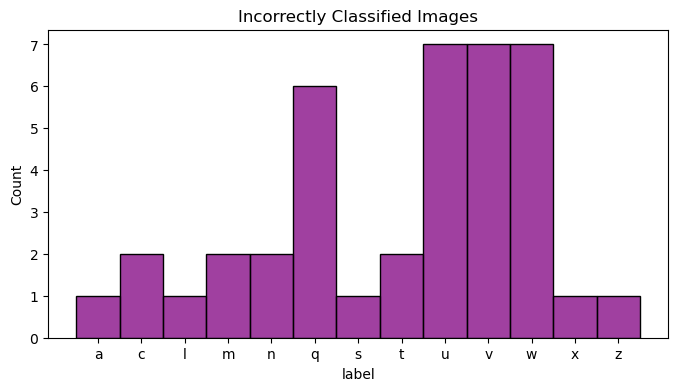

In [72]:
plt.figure(figsize=(8, 4))
ax = sns.histplot(data=df[df["correct"] == False], x="label", color='purple')
ax.set_title('Incorrectly Classified Images')
plt.show()